In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
%load_ext autoreload

In [2]:
import torch
torch.set_float32_matmul_precision('high')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from os.path import join
import yaml

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier, LinearClassifier

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [4]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

# Scaling with respect to training data size

In [5]:
from sklearn.metrics import classification_report
from utils import get_best_ckpts, correct_labels
import gc

In [6]:
LOGS_PATH = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'


CKPTS_DONOR_SUBSAMPLING = {
    'subset_15': get_best_ckpts(LOGS_PATH, [f'subset_15_{i}' for i in range(1, 5)]),
    'subset_30': get_best_ckpts(LOGS_PATH, [f'subset_30_{i}' for i in range(1, 5)]),
    'subset_50': get_best_ckpts(LOGS_PATH, [f'subset_50_{i}_new3' for i in range(1, 5)]),  # Rerun cause this was not trained long enough
    'subset_70': get_best_ckpts(LOGS_PATH, [f'subset_70_{i}' for i in range(1, 5)]),
    'subset_100': get_best_ckpts(LOGS_PATH, [f'w_augment_{i}' for i in range(1, 5)])
}
CKPTS_RANDOM_SUBSAMPLING = {
    'subsample_15': get_best_ckpts(LOGS_PATH, [f'random_subsample_15_{i}' for i in range(1, 5)]),
    'subsample_30': get_best_ckpts(LOGS_PATH, [f'random_subsample_30_{i}_new' for i in range(1, 5)]),  # Rerun cause this was trained too long
    'subsample_50': get_best_ckpts(LOGS_PATH, [f'random_subsample_50_{i}_new3' for i in range(1, 5)]),  # Rerun cause this was not trained long enough
    'subsample_70': get_best_ckpts(LOGS_PATH, [f'random_subsample_70_{i}' for i in range(1, 5)]),
    'subsample_100': get_best_ckpts(LOGS_PATH, [f'w_augment_{i}' for i in range(1, 5)])
}

In [7]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt


def millions_formatter(x, pos):
    return f'{int(x / 1000000)}M'


formatter = ticker.FuncFormatter(millions_formatter)

## Training data size vs number of donors (donor based subsampling)

In [8]:
path_template = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p{subsample}'


n_donors = []
n_train_samples = []

for subsample in ['_subsample_15', '_subsample_30', '_subsample_50', '_subsample_70', '']:
    tech_samples = (
        dd.read_parquet(join(path_template.format(subsample=subsample), 'train'), columns='tech_sample')
        .compute()
    )
    n_donors.append(tech_samples.nunique())
    n_train_samples.append(len(tech_samples))


## Overall statistics

In [ ]:
import gc


n_training_samples = []
subsampling = []
f1_score = []
loss = []
ckpt_list = []


estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=4096)
device = 'gpu' if torch.cuda.is_available() else 'cpu'
estim.trainer = pl.Trainer(logger=[], accelerator=device, devices=1)


try:
    res_df = pd.read_csv('model_eval_cache/data_scaling.csv')
except FileNotFoundError:
    res_df = pd.DataFrame({
        'n_training_samples': [],
        'subsamping_strategy': [],
        'f1_score': [],
        'loss': [],
        'ckpt': []
    })


for sampling_strategy, ckpts_dict in [('donor_based', CKPTS_DONOR_SUBSAMPLING), ('random', CKPTS_RANDOM_SUBSAMPLING)]:
    for _, ckpts in ckpts_dict.items():
        for ckpt in ckpts:
            if ckpt in res_df.ckpt.tolist():
                # use cached data if available
                run = (res_df.ckpt == ckpt) & (res_df.subsamping_strategy == sampling_strategy)
                f1_ckpt = float(res_df.loc[run, 'f1_score'])
                loss_ckpt = float(res_df.loc[run, 'loss'])
                print(
                    f"Reusing {ckpt.split('/')[-1]} checkpoint: f1-score={f1_ckpt:.4f} loss={loss_ckpt:.4f}"
                )
                subsampling.append(sampling_strategy)
                ckpt_list.append(ckpt)
                n_training_samples.append(int(res_df.loc[run, 'n_training_samples']))
                f1_score.append(float(res_df.loc[run, 'f1_score']))
                loss.append(float(res_df.loc[run, 'loss']))
            else:
                subsampling.append(sampling_strategy)
                ckpt_list.append(ckpt)
                with open(join(ckpt.split('checkpoints')[0], 'hparams.yaml')) as f:
                    hparams = yaml.full_load(f.read())
                    n_training_samples.append(hparams['train_set_size'])

                estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
                res = estim.test()[0]
                f1_score.append(res['test_f1_macro'])
                loss.append(res['test_loss'])
                gc.collect()


In [14]:
res_df = pd.DataFrame({
    'n_training_samples': n_training_samples,
    'subsamping_strategy': subsampling,
    'f1_score': f1_score,
    'loss': loss,
    'ckpt': ckpt_list
})
res_df.to_csv('data_scaling.csv')

In [15]:
res_df['subsamping_strategy'] = res_df['subsamping_strategy'].replace({
    'donor_based': 'donor-based sampling',
    'random': 'cell-based sampling',
})

/tmp/ipykernel_1654317/856679493.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{tick:.2f}' for tick in ax2.get_yticks()])


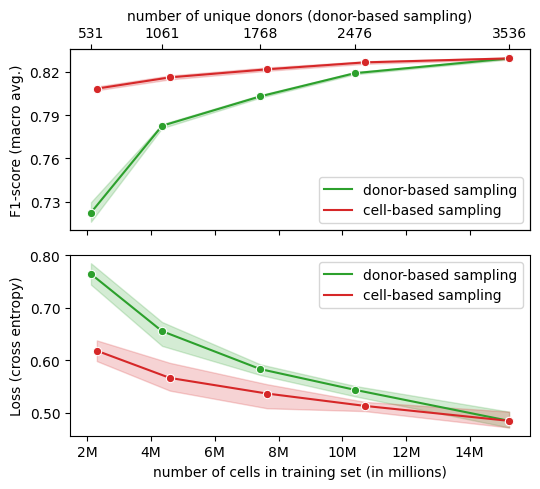

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.5, 5.), sharex=True)


sns.lineplot(
    x='n_training_samples',
    y='f1_score',
    hue='subsamping_strategy',
    marker='o',
    palette=sns.color_palette()[2:4],
    data=res_df,
    ax=ax1
)
ax1.xaxis.set_major_formatter(formatter)
ax1.set_xlabel('number of cells in training set (in millions)')
ax1.set_ylabel('F1-score (macro avg.)')
ax1.set_yticks([0.73, 0.76, 0.79, 0.82])
ax1.legend(title='')
ax1_upper = ax1.twiny()
ax1_upper.set_xlim(ax1.get_xlim())
ax1_upper.set_xticks(n_train_samples)
ax1_upper.set_xticklabels(n_donors)
ax1_upper.set_xlabel('number of unique donors (donor-based sampling)')

sns.lineplot(
    x='n_training_samples',
    y='loss',
    hue='subsamping_strategy',
    marker='o',
    palette=sns.color_palette()[2:4],
    data=res_df,
    ax=ax2
)
ax2.xaxis.set_major_formatter(formatter)
ax2.set_xlabel('number of cells in training set (in millions)')
ax2.set_yticklabels([f'{tick:.2f}' for tick in ax2.get_yticks()])
ax2.set_ylabel('Loss (cross entropy)')
ax2.legend(title='')


plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/donor_vs_random_sampling.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/donor_vs_random_sampling.png', dpi=300)

## Statistics grouped by BioNetwork

In [ ]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
tissue_general = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

In [ ]:
preds = []
n_training_samples = []
ckpt_list = []


estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=4096)
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)


for subset, ckpts in CKPTS_DONOR_SUBSAMPLING.items():
    for ckpt in ckpts:
        ckpt_list.append(ckpt)
        with open(join(ckpt.split('checkpoints')[0], 'hparams.yaml')) as f:
            hparams = yaml.full_load(f.read())
            n_training_samples.append(hparams['train_set_size'])

        estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
        probas = estim.predict(estim.datamodule.test_dataloader())
        preds.append(correct_labels(y_true, np.argmax(probas, axis=1), cell_type_hierarchy))
        gc.collect()


In [ ]:
import pickle


pickle.dump((preds, n_training_samples, ckpt_list), open('preds.pickle', 'wb'))

In [ ]:
import pickle


with open('preds.pickle', 'rb') as f:
    preds, n_training_samples, ckpt_list = pickle.load(f)

In [ ]:
%autoreload
from utils import BIONETWORK_GROUPING
from typing import Dict, List


def macro_f1_per_group(y_true, y_pred, group_variable, grouping: Dict[str, List[str]]):
    assert len(y_true) == len(y_pred) == len(group_variable)
    groups = []
    f1_macro = []

    for group, group_assignments in grouping.items():
        y_pred_group = y_pred[np.isin(group_variable, group_assignments).squeeze()]
        y_true_group = y_true[np.isin(group_variable, group_assignments).squeeze()]
        clf_report = pd.DataFrame(classification_report(
            y_true=y_true_group,
            y_pred=y_pred_group,
            labels=np.unique(y_true_group),
            output_dict=True,
            zero_division=0
        )).T
        groups.append(group)
        f1_macro.append(clf_report.loc['macro avg', 'f1-score'])

    return pd.DataFrame({'group': groups, 'f1_score': f1_macro})


In [ ]:
tissue = tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
res = {'bionetwork': [], 'f1_score': [], 'n_training_samples': []}


for y_pred, training_samples in zip(preds, n_training_samples):
    f1_score_per_bionetwork = macro_f1_per_group(y_true, y_pred, tissue, BIONETWORK_GROUPING)
    res['bionetwork'] += f1_score_per_bionetwork.group.tolist()
    res['f1_score'] += f1_score_per_bionetwork.f1_score.tolist()
    res['n_training_samples'] += [training_samples] * len(f1_score_per_bionetwork)

res = pd.DataFrame(res)

In [14]:
res.to_csv('model_eval_cache/model_scaling_per_bionetwork.csv', index=False)

In [33]:
res = pd.read_csv('model_eval_cache/model_scaling_per_bionetwork.csv')

In [34]:
res['bionetwork'] = (
    res['bionetwork'].str.replace('_', ' ')
    .replace({
        'oral and craniofacial': 'oral+craniofacial',
        'blood and immune': 'blood+immune'
    })
)

/tmp/ipykernel_1654317/1917718049.py:5: UserWarning: The palette list has more values (20) than needed (14), which may not be intended.
  sns.lineplot(


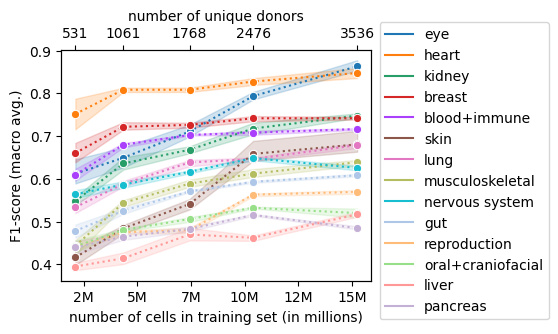

In [35]:
from scanpy.plotting.palettes import default_20


fig, ax = plt.subplots(1, 1, figsize=(4., 3.))
sns.lineplot(
    x='n_training_samples', 
    y='f1_score', 
    hue='bionetwork', 
    hue_order=(
        res[res.bionetwork != 'adipose']
        .query('n_training_samples == 15240192')
        .groupby('bionetwork').mean()
        .sort_values('f1_score', ascending=False)
        .index.tolist()
    ),
    marker='o', 
    linestyle=':',
    err_style='band',
    palette=default_20,
    data=res[res.bionetwork != 'adipose'],
    ax=ax
)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('number of cells in training set (in millions)')
# ax.set_ylim(0. ,1.)
ax.set_ylabel('F1-score (macro avg.)')
ax.legend(title='Organ System')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(n_train_samples)
ax2.set_xticklabels(n_donors)
ax2.set_xlabel('number of unique donors')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 0.95))

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.3, 1.15))

plt.savefig(
    '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/scaling_per_organ_system.pdf',
    bbox_extra_artists=(lgd, ), 
    bbox_inches='tight'
)
plt.savefig(
    '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/scaling_per_organ_system.png', 
    dpi=300,
    bbox_extra_artists=(lgd, ), 
    bbox_inches='tight'
)

In [17]:
from utils import BIONETWORK_GROUPING


obs_train = dd.read_parquet(
    join(DATA_PATH, 'train'), 
    columns=['tissue_general', 'cell_type', 'tech_sample'], 
    split_row_groups=True
).compute()
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
tissue = tissue_general_mapping.loc[obs_train.tissue_general].to_numpy().flatten()
cell_types = obs_train.cell_type.to_numpy()
tech_samples = obs_train.tech_sample.to_numpy()

tissue_summary = {'tissue': [], 'n_cells': [], 'n_cell_types': [], 'n_donors': []}
for group, group_assignments in BIONETWORK_GROUPING.items():
    cell_types_tissue = cell_types[np.isin(tissue, group_assignments)]
    tissue_summary['tissue'].append(group)
    tissue_summary['n_cells'].append(len(cell_types_tissue))
    tissue_summary['n_cell_types'].append(len(np.unique(cell_types_tissue)))
    tissue_summary['n_donors'].append(len(np.unique(
        tech_samples[np.isin(tissue, group_assignments)]
    )))

tissue_summary = pd.DataFrame(tissue_summary)
tissue_summary['tissue'] = (
    tissue_summary['tissue'].str.replace('_', ' ')
    .replace({
        'oral and craniofacial': 'oral+craniofacial',
        'blood and immune': 'blood+immune'
    })
)
tissue_summary = tissue_summary.set_index('tissue')
tissue_summary['f1_score'] = res.query('n_training_samples == 15240192').groupby('bionetwork')['f1_score'].mean()

In [18]:
(
    tissue_summary[['n_cell_types', 'n_cells', 'n_donors', 'f1_score']]
    .assign(
        n_cells=lambda df: np.log(df.n_cells),
        n_donors=lambda df: np.log(df.n_donors)
    )
    .corr()[['f1_score']]
)

,f1_score
n_cell_types,-0.546303
n_cells,-0.108006
n_donors,-0.081254
f1_score,1.000000


In [20]:
from scipy.stats import pearsonr

# compute p-value for f1-score / n_cell_types correlation
pearsonr(tissue_summary.f1_score, tissue_summary.n_cell_types)

PearsonRResult(statistic=-0.5463034007214954, pvalue=0.0351169140580146)

In [7]:
f1_scores_small = (
    res
    .query('n_training_samples == 2108416')
    [['bionetwork', 'f1_score']]
    .groupby('bionetwork')['f1_score']
    .agg(['mean', 'std'])
)

In [8]:
f1_scores_big = (
    res
    .query('n_training_samples == 15240192')
    [['bionetwork', 'f1_score']]
    .groupby('bionetwork')['f1_score']
    .agg(['mean', 'std'])
)

In [9]:
from scipy.stats import bootstrap

In [11]:
median = (f1_scores_big - f1_scores_small)['mean'].median()
median_std = bootstrap(
    ((f1_scores_big - f1_scores_small)['mean'].to_numpy(), ), 
    np.median, 
    random_state=1
).standard_error

print(f'Median: {median:.4f}±{median_std:.4f}')

Median: 0.1219±0.0212


In [13]:
minimum = (f1_scores_big - f1_scores_small)['mean'].min()
minimum_std = bootstrap(
    ((f1_scores_big - f1_scores_small)['mean'].to_numpy(), ), 
    np.min, 
    random_state=1
).standard_error

print(f'{minimum:.4f}±{minimum_std:.4f}')

0.0454±0.0083


## TabNet vs Linear

In [17]:
LOGS_PATH_TABNET = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'
LOGS_PATH_LINEAR = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_linear/default'


CKPTS_TABNET = {
    'tabnet_15': get_best_ckpts(LOGS_PATH_TABNET, [f'subset_15_{i}_augmentation=False' for i in range(1, 4)]),
    'tabnet_30': get_best_ckpts(LOGS_PATH_TABNET, [f'subset_30_{i}_augmentation=False' for i in range(1, 4)]),
    'tabnet_50': get_best_ckpts(LOGS_PATH_TABNET, [f'subset_50_{i}_augmentation=False' for i in range(1, 4)]),
    'tabnet_70': get_best_ckpts(LOGS_PATH_TABNET, [f'subset_70_{i}_augmentation=False' for i in range(1, 4)]),
    'tabnet_100': get_best_ckpts(LOGS_PATH_TABNET, [f'w_augment_{i}' for i in range(1, 4)])
}
CKPTS_LINEAR = {
    'linear_15': get_best_ckpts(LOGS_PATH_LINEAR, [f'subset_15_{i}' for i in range(1, 4)]),
    'linear_30': get_best_ckpts(LOGS_PATH_LINEAR, [f'subset_30_{i}' for i in range(1, 4)]),
    'linear_50': get_best_ckpts(LOGS_PATH_LINEAR, [f'subset_50_{i}' for i in range(1, 4)]),
    'linear_70': get_best_ckpts(LOGS_PATH_LINEAR, [f'subset_70_{i}' for i in range(1, 4)]),
    'linear_100': get_best_ckpts(
        '/mnt/dssfs02/tb_logs/juwles/cxg_2023_05_15_linear/default',
        [f'version_{i}' for i in range(1, 4)]
    )
}

In [18]:
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

In [ ]:
import gc


n_training_samples = []
models = []
f1_score = []
ckpt_list = []


try:
    res_df = pd.read_csv('model_eval_cache/linear_vs_tabnet.csv')
except FileNotFoundError:
    res_df = pd.DataFrame({
        'n_training_samples': [],
        'model': [],
        'f1_score': [],
        'ckpt': []
    })

    
estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=4096)
device = 'gpu' if torch.cuda.is_available() else 'cpu'
estim.trainer = pl.Trainer(logger=[], accelerator=device, devices=1)


for model, ckpts_dict in [('linear', CKPTS_LINEAR), ('tabnet', CKPTS_TABNET)]:
    for _, ckpts in ckpts_dict.items():
        for ckpt in ckpts:
            if ckpt in res_df.ckpt.tolist():
                # use cached data if available
                run = (res_df.ckpt == ckpt) & (res_df.model == model)
                f1_ckpt = float(res_df.loc[run, 'f1_score'])
                print(
                    f"Reusing {ckpt.split('/')[-1]} checkpoint: f1-score={f1_ckpt:.4f}"
                )
                models.append(model)
                ckpt_list.append(ckpt)
                n_training_samples.append(int(res_df.loc[run, 'n_training_samples']))
                f1_score.append(float(res_df.loc[run, 'f1_score']))
            else:
                models.append(model)
                ckpt_list.append(ckpt)
                with open(join(ckpt.split('checkpoints')[0], 'hparams.yaml')) as f:
                    hparams = yaml.full_load(f.read())
                    n_training_samples.append(hparams['train_set_size'])
                
                if model == 'tabnet':
                    estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
                elif model == 'linear':
                    estim.model = LinearClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('linear'))

                probas = estim.predict(estim.datamodule.test_dataloader())
                y_pred = correct_labels(y_true, np.argmax(probas, axis=1), cell_type_hierarchy)
                clf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, zero_division=0)).T
                f1_score.append(float(clf_report.loc['macro avg', 'f1-score']))
                gc.collect()


In [22]:
res_df = pd.DataFrame({
    'n_training_samples': n_training_samples,
    'model': models,
    'f1_score': f1_score,
    'ckpt': ckpt_list
})
res_df.to_csv('model_eval_cache/linear_vs_tabnet.csv')

In [36]:
res_df = pd.read_csv('model_eval_cache/linear_vs_tabnet.csv', index_col=0)

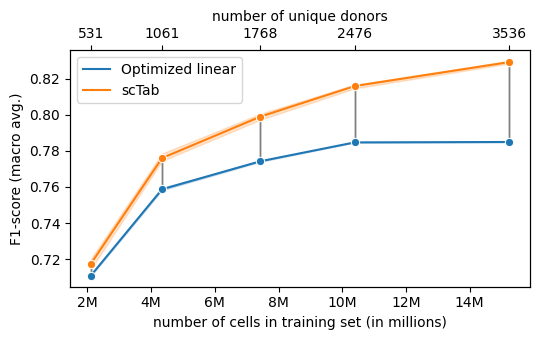

In [37]:
mean_linear = res_df[res_df.model == 'linear'].groupby('n_training_samples')['f1_score'].mean().to_numpy()
mean_tabnet = res_df[res_df.model == 'tabnet'].groupby('n_training_samples')['f1_score'].mean().to_numpy() 

fig, ax = plt.subplots(1, 1, figsize=(5.5, 3.5))
sns.lineplot(
    x='n_training_samples',
    y='f1_score',
    hue='model',
    marker='o',
    data=res_df.assign(model=lambda x: x.model.replace({'tabnet': 'scTab', 'linear': 'Optimized linear'})),
)
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('number of cells in training set (in millions)')
ax.set_ylabel('F1-score (macro avg.)')
for i in range(0, len(mean_linear)):
    ax.arrow(
        x=np.unique(res_df.n_training_samples)[i],
        y=mean_linear[i],
        dx=0.,
        dy=(mean_tabnet - mean_linear)[i],
        length_includes_head=True,
        alpha=0.5
    )
ax.legend(title='')


ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(n_train_samples)
ax2.set_xticklabels(n_donors)
ax2.set_xlabel('number of unique donors')

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/linear_vs_tabnet.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/linear_vs_tabnet.png', dpi=300)

# F1-score vs model size

In [26]:
CKPTS_MODEL_SCALING = {
    16: get_best_ckpts(LOGS_PATH, [f'model_scaling_n_d=16_n_a=16_run{i}' for i in range(1, 4)]),
    32: get_best_ckpts(LOGS_PATH, [f'model_scaling_n_d=32_n_a=32_run{i}' for i in range(1, 4)]),
    64: get_best_ckpts(LOGS_PATH, [f'model_scaling_n_d=64_n_a=64_run{i}' for i in range(1, 4)]),
    128: get_best_ckpts(LOGS_PATH, [f'model_scaling_n_d=128_n_a=64_run{i}' for i in range(1, 4)]),
    256: get_best_ckpts(LOGS_PATH, [f'model_scaling_n_d=256_n_a=64_run{i}' for i in range(1, 4)])
}

In [28]:
import gc


n_hidden = []
f1_score = []
ckpt_list = []

estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=4096)
device = 'gpu' if torch.cuda.is_available() else 'cpu'
estim.trainer = pl.Trainer(logger=[], accelerator=device, devices=1)
try:
    res_df = pd.read_csv('model_eval_cache/model_scaling.csv', index_col=0)
except FileNotFoundError:
    res_df = pd.DataFrame({'n_hidden': [], 'f1_score': [], 'ckpt': []})


for n_d, ckpts in CKPTS_MODEL_SCALING.items():
    for ckpt in ckpts:
        if ckpt in res_df.ckpt.tolist():
            # use cached data if available
            f1_ckpt = float(res_df.loc[res_df.ckpt == ckpt, 'f1_score'])
            print(
                f"Reusing {ckpt.split('/')[-1]} checkpoint: f1-score={f1_ckpt:.4f}"
            )
            ckpt_list.append(ckpt)
            n_hidden.append(n_d)
            f1_score.append(f1_ckpt)
        else:
            n_hidden.append(n_d)
            ckpt_list.append(ckpt)
            estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
            res = estim.test()[0]
            f1_score.append(res['test_f1_macro'])
            gc.collect()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Reusing val_f1_macro_epoch=46_val_f1_macro=0.806.ckpt checkpoint: f1-score=0.7875
Reusing val_f1_macro_epoch=44_val_f1_macro=0.807.ckpt checkpoint: f1-score=0.7855
Reusing val_f1_macro_epoch=47_val_f1_macro=0.806.ckpt checkpoint: f1-score=0.7863
Reusing val_f1_macro_epoch=45_val_f1_macro=0.829.ckpt checkpoint: f1-score=0.8103
Reusing val_f1_macro_epoch=44_val_f1_macro=0.825.ckpt checkpoint: f1-score=0.8097
Reusing val_f1_macro_epoch=45_val_f1_macro=0.825.ckpt checkpoint: f1-score=0.8079
Reusing val_f1_macro_epoch=43_val_f1_macro=0.842.ckpt checkpoint: f1-score=0.8219
Reusing val_f1_macro_epoch=46_val_f1_macro=0.842.ckpt checkpoint: f1-score=0.8235
Reusing val_f1_macro_epoch=45_val_f1_macro=0.842.ckpt checkpoint: f1-score=0.8263
Reusing val_f1_macro_epoch=43_val_f1_macro=0.848.ckpt checkpoint: f1-score=0.8290
Reusing val_f1_macro_epoch=42_val_f1_macro=0.848.ckpt checkpoint: f1-score=0.8312
Reusing val_f1_macro_epoch=44_val_f1_macro=0.847.ckpt checkpoint: f1-score=0.8309
Reusing val_f1_m

In [29]:
res_df2 = pd.DataFrame({'n_hidden': n_hidden, 'f1_score': f1_score, 'ckpt': ckpt_list})
res_df2.to_csv('model_eval_cache/model_scaling.csv')

In [30]:
performance_linear = pd.read_csv('model_eval_cache/model_comparision.csv', index_col=0).query('model == "linear"')['f1-score (macro avg.)'].mean()

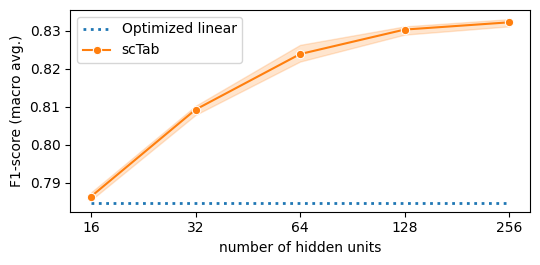

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 2.75))
ax1.hlines(performance_linear, xmin=res_df2.n_hidden.min(), xmax=res_df2.n_hidden.max(), label='Optimized linear', lw=2, linestyles='dotted')

sns.lineplot(
    x='n_hidden',
    y='f1_score',
    marker='o',
    data=res_df2,
    ax=ax1,
    color=sns.color_palette()[1],
    label='scTab'
)
ax1.set_xlabel('number of hidden units')
ax1.set_ylabel('F1-score (macro avg.)')
ax1.set_xscale('log', base=2)
xticks = np.unique(res_df2.n_hidden)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)
plt.legend()

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/model-scaling.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/model-scaling.png', dpi=300)

In [32]:
res_df2.groupby('n_hidden')['f1_score'].agg(['mean', 'std'])

,mean,std
n_hidden,,
16,0.786417,0.001022
32,0.809308,0.001244
64,0.823915,0.002229
128,0.830362,0.001166
256,0.832272,0.000969
